## *Import Librairies, Define Variables, Test Connexion*

In [2]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time
import math

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import pmdarima.arima as pm

from dateutil.easter import easter

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [24]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC1_fig'

# @param Connexion à la DB
driver= '{ODBC Driver 17 for SQL Server}'
server = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login = ('DRIVER=' + driver + 
         ';SERVER=' + server + 
         ';Trusted_Connection=yes;')


# @param Definition des table et colonnes --> Dépendent de la DB
DB      = "Archive2018_2019_prod"
TABLE   = "Recette_entete_ticket"
TEMPS   = TABLE                   + ".TEMPS.KEY_Date_reel_de_la_transaction"
RECETTE = TABLE                   + ".Total_net_ticket_ttc"
MAGASIN = TABLE                   + ".MAGASIN"


# @param Variable influançant la sélection des données
number_data   = 20263177            # Nombre de données à sélectionner au maximum. MAX = 20263177 avec contraintes
start_date    = date(2019,1,1)      # Date de début des données à sélectionner
end_date      = date(2019,12,1)      # Date de fin des données à sélectionner
column_wanted = [                   # Liste des colonnes voulues
       "["+TABLE+".KEY]"
      ,"["+TEMPS+"]"
      ,"["+RECETTE+"]"
      ,"["+MAGASIN+".KEY]"
]                                                    
Eat_and_Go_KEYS = [8,18,28,35,36]   # All keys of Eat&Go shops 
take_EG         = False             # Does we take only E&G or does we take only not E&G ? 

do_log = False

# @param Input pour la créations du modèles prédictif
alpha = 0.8                  # Proportion de la taille des données de test et de train
season = 7                   # Taille de saisonnalité des données (7 jours pour une saisons par semaines)
METHOD = 'lbfgs'             # Méthode utiliser pour fit le modèle
#          Error Moyenne (%)  Temps Process (s)
# newton                 NaN               NaN
# nm               12.929560        108.056167   t=539s bad: 16   moyen: 14   good: 6  ---  E&G t=26s bad: 1   moyen: 0   good: 0
# bfgs             12.620287        556.962607 
# powell           12.670451        379.438504
# lbfgs            12.481309        419.550971   t=770s bad: 9   moyen: 16   good: 10  ---  E&G t=35s bad: 1   moyen: 0   good: 0
# cg               15.907566        217.617969   
# ncg                    NaN               NaN
# basinhopping           NaN               inf


# @param Définition du score d'erreur pour une de bonne/moyenne/mauvaise prédiction
BAD  = .18         # Mauvaise prédiction si score supérieur à BAD
GOOD = .12         # Bonne    prédiction si score inférieur à GOOD


In [25]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) "+column_wanted[1]+" FROM ["+DB+"].[DWH].[Fact_"+TABLE+"]", conn)
print(df)

conn.close()

   Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction
0                                           20190604          
1                                           20190604          
2                                           20190604          
3                                           20190604          
4                                           20190604          
5                                           20190604          
6                                           20190604          
7                                           20190604          
8                                           20190604          
9                                           20190604          


## *Prediction du CA en fonction du temps pour TOUT*

In [26]:
def date_to_key(d):
    return d.year*10000 + d.month*100 + d.day

sql_command = "SELECT TOP (" + str(number_data) + ") "
for cw in column_wanted:
    sql_command += '\n' + cw + ','
sql_command = sql_command[:-1] + '''  
FROM  [''' + DB      + '''].[DWH].[Fact_''' + TABLE + ''']
WHERE [''' + RECETTE + '''] != 0  
AND ['''   + TEMPS   + '''] > ''' + str(date_to_key(start_date)) + '''
AND ['''   + TEMPS   + '''] < ''' + str(date_to_key(end_date))   + '''
AND ['''   + TABLE   + '''.Nombre_articles] > 0 '''

if not take_EG:
    for key in Eat_and_Go_KEYS:
        sql_command += "\nAND NOT " +  "["+MAGASIN+".KEY] = " + str(key)
else: 
    sql_command += "\nAND ("
    for key in Eat_and_Go_KEYS:
        sql_command += "["+MAGASIN+".KEY] = " + str(key) + " \nOR "
    sql_command = sql_command[:-3]+")"

print(sql_command)

start = time()

conn = engine.connect()
df = pd.read_sql(sql_command, conn)
conn.close()

# environ 2 min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 

number_data = len(df.values)
print(number_data)

SELECT TOP (20263177) 
[Recette_entete_ticket.KEY],
[Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction],
[Recette_entete_ticket.Total_net_ticket_ttc],
[Recette_entete_ticket.MAGASIN.KEY]  
FROM  [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket]
WHERE [Recette_entete_ticket.Total_net_ticket_ttc] != 0  
AND [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] > 20190101
AND [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] < 20191201
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 8
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 18
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 28
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 35
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 36
Time Taken to load DB: ~43secondes
5734638


In [27]:
start = time()

### -------------- Find an improvment because it takes a lot of time ! ------------------------- ###

Tot_recette_day = {}

correspondance_day = {}

d = start_date + timedelta(days=1)
while d < end_date:
    correspondance_day[date_to_key(d)] = d
    Tot_recette_day[d] = 0
    d += timedelta(days=1)

temps_in_date = []
for i in range(number_data):
    d = correspondance_day[df[TEMPS][i]]
    temps_in_date.append(d)
    Tot_recette_day[d] += df[RECETTE][i]

df[TEMPS + "in date"] = temps_in_date

if do_log:
    for key in Tot_recette_day.keys():
        Tot_recette_day[key] = math.log(Tot_recette_day[key])/math.log(10)

# environ 2 min
print("Time Taken to change date to datetime: ~" + str(int(time() - start)) + "secondes") 

Time Taken to change date to datetime: ~59secondes


<AxesSubplot:>

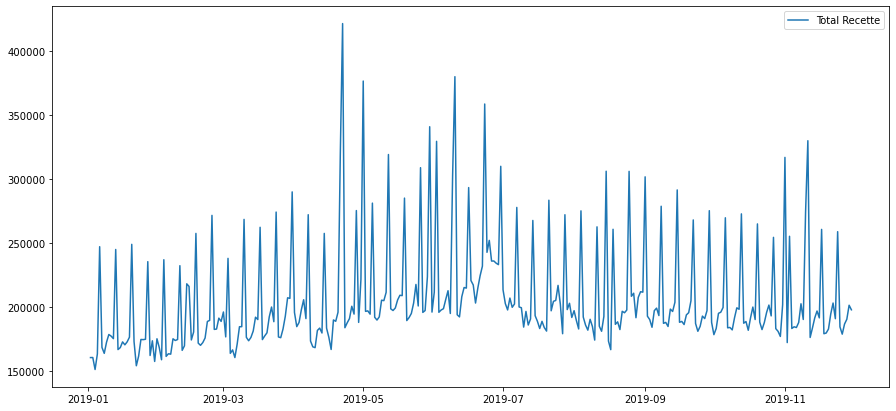

In [28]:
 #Sort the items by date is necessary, sometimes it isn't sorted ! ~30 items/month so it's fast
Tot_recette_day = dict(sorted(Tot_recette_day.items()))

df_recette_day = pd.DataFrame(data = Tot_recette_day.values(), index=Tot_recette_day.keys(), columns = ["Total Recette"])
df_recette_day.plot(figsize=(15,7))

<AxesSubplot:>

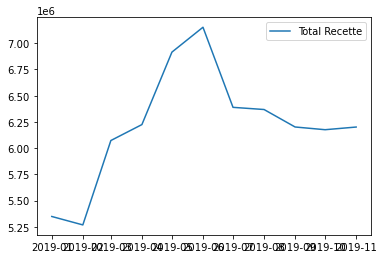

In [29]:
Tot_recette_month = {}
for k,v in Tot_recette_day.items():
    if not date(k.year, k.month, 1) in Tot_recette_month.keys():
        Tot_recette_month[date(k.year, k.month, 1)] = 0
    Tot_recette_month[date(k.year, k.month, 1)] += v

    
df_recette_month = pd.DataFrame(data = Tot_recette_month.values(), index=Tot_recette_month.keys(), columns = ["Total Recette"])
df_recette_month.plot()

In [30]:
ts_main = pd.Series(data = df_recette_day[df_recette_day.columns[0]], index=df_recette_day.index)
print(ts_main)

2019-01-02    160225.42
2019-01-03    160262.50
2019-01-04    150905.63
2019-01-05    163057.71
2019-01-06    246829.24
                ...    
2019-11-26    178521.36
2019-11-27    186388.53
2019-11-28    190136.14
2019-11-29    201107.66
2019-11-30    197541.15
Name: Total Recette, Length: 333, dtype: float64


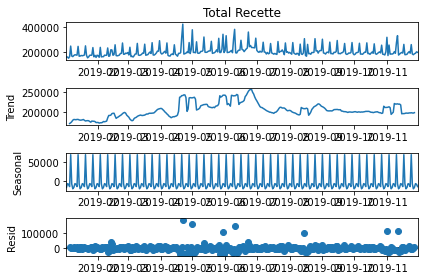

In [31]:
decomp = sm.tsa.seasonal_decompose(ts_main, period = season, model='additive')
decomp.plot()
plt.show()

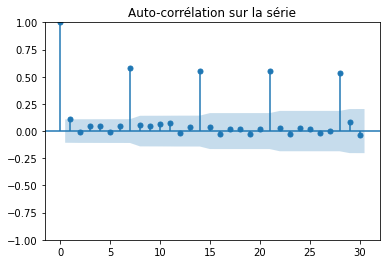

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


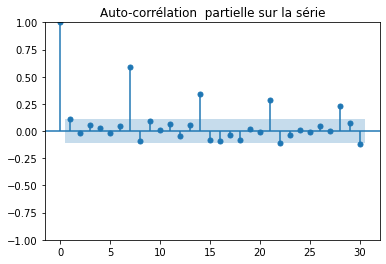

In [32]:
plot_acf(ts_main,lags = 30, title = "Auto-corrélation sur la série")
plt.show()
plot_pacf(ts_main, lags = 30, title = "Auto-corrélation  partielle sur la série")
plt.show()

In [33]:
def stationarity_test(ts):
    df_test = adfuller(ts, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of observations used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    return df_output
print(stationarity_test(ts_main))

Test Statistic                  -2.377010
p-value                          0.148331
#Lags Used                      15.000000
Number of observations used    317.000000
Critical Value (1%)             -3.451148
Critical Value (5%)             -2.870701
Critical Value (10%)            -2.571651
dtype: float64


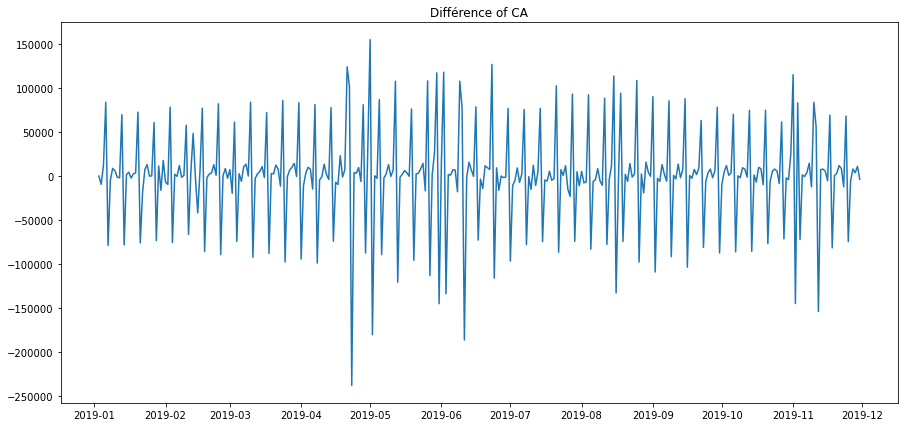

In [34]:
ts_d1 = pd.Series(data=ts_main - ts_main.shift(1), index=ts_main.index).dropna()       

plt.figure(figsize=(15,7))
plt.plot(ts_d1.index, ts_d1.values)
plt.title("Différence of CA")
plt.show()

In [35]:
print(stationarity_test(ts_d1))

Test Statistic                -1.068829e+01
p-value                        3.783252e-19
#Lags Used                     1.200000e+01
Number of observations used    3.190000e+02
Critical Value (1%)           -3.451017e+00
Critical Value (5%)           -2.870643e+00
Critical Value (10%)          -2.571620e+00
dtype: float64


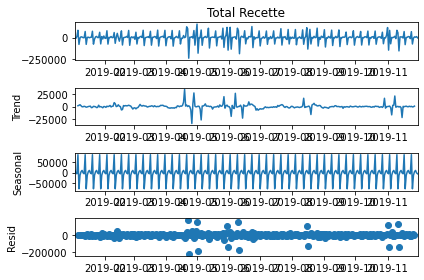

In [36]:
decomp_d1 = sm.tsa.seasonal_decompose(ts_d1,period = season, model='additive')
decomp_d1.plot()
plt.show()

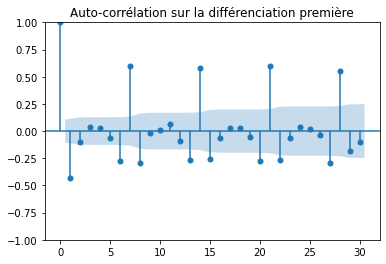

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


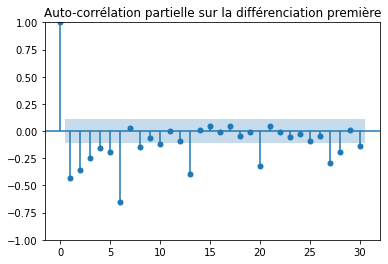

In [37]:
plot_acf(ts_d1,lags = 30, title = "Auto-corrélation sur la différenciation première")
plt.show()
plot_pacf(ts_d1, lags = 30, title = "Auto-corrélation partielle sur la différenciation première")
plt.show()

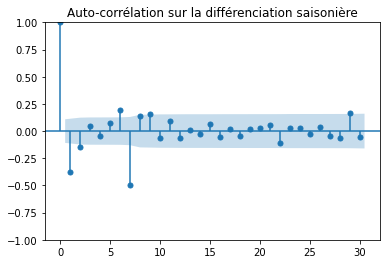

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


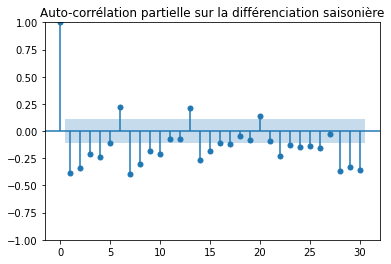

In [38]:
ts_d1d12 = pd.Series(data=ts_d1 - ts_d1.shift(season), index=ts_d1.index).dropna()  

plot_acf(ts_d1d12,lags = 30, title = "Auto-corrélation sur la différenciation saisonière")
plt.show()
plot_pacf(ts_d1d12, lags = 30, title = "Auto-corrélation partielle sur la différenciation saisonière")
plt.show()

In [39]:
start = time()

train_main, val_main = train_test_split(ts_main,test_size = 1-alpha, shuffle = False)

auto_model = pm.auto_arima(train_main,d=0,D=1,seasonal=True, m=season, method = METHOD).fit(train_main)

# bfgs powell lbfgs cg <--- Method OK  
# basinhopping <----------- Method OK but long

# environ 10s
print("Time Taken to train model: ~" + str(int(time() - start)) + "secondes") 

Time Taken to train model: ~31secondes


In [40]:
def cal_error(prediction, validation):
    # ERREURS QUADRATIQUES 
    N = len(prediction)
    
    erreurs_quad = [(prediction[i] - validation[i])**2 for i in range(N)]
    
    MSE = (sum(erreurs_quad)/N)
    RMSD = MSE**0.5
    NRMSD = RMSD/(max(validation-min(validation)))
    
    return NRMSD

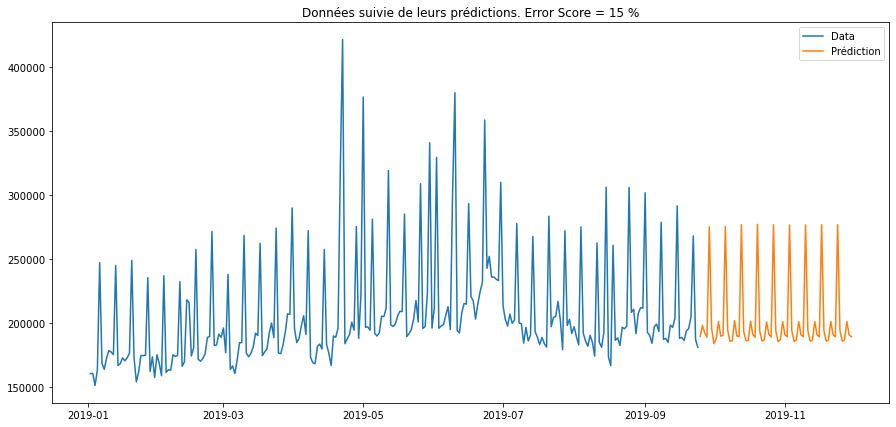

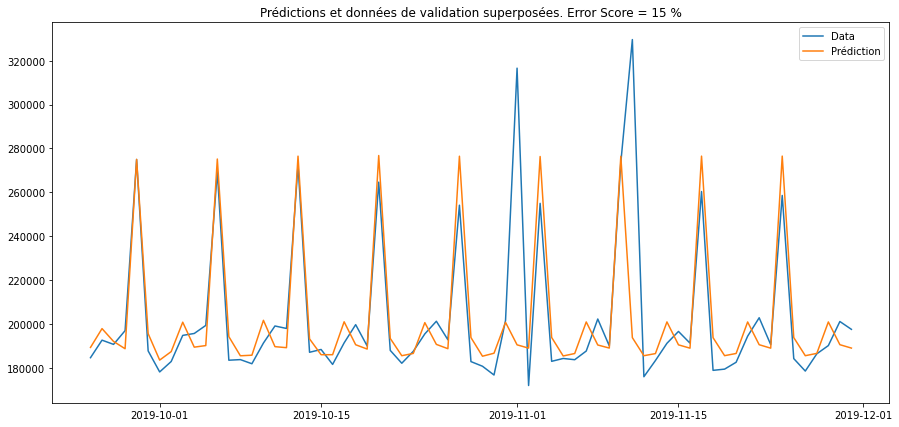

In [41]:
pred = auto_model.predict(n_periods = len(val_main))
pred = pd.Series(data=pred, index=[train_main.index[-1] +timedelta(days=i+1) for i in range(len(pred))])

err = cal_error(pred, val_main)

train_main.plot(label="Data",legend=True, figsize=(15,7))
pred.plot(label="Prédiction" ,legend=True)
plt.title("Données suivie de leurs prédictions"+ " E&G"*int(take_EG) +". Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/ALL_prediction1" + "_E&G"*int(take_EG) + ".jpg")
plt.show()

val_main.plot(label="Data",legend=True, figsize=(15,7))
pred.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions et données de validation superposées"+ " E&G"*int(take_EG) +". Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/ALL_prediction2" + "_E&G"*int(take_EG) + ".jpg")
plt.show()

In [42]:
def Recalc_with_feries(prediction):
    jours_feries = []

    d = min(prediction.index)
    while d <= max(prediction.index):
        if d.day == 1 and d.month == 1:
            jours_feries.append(d)
        elif d.day == 1 and d.month == 5:
            jours_feries.append(d)
        elif d.day == 21 and d.month == 7:
            jours_feries.append(d)
        elif d.day == 15 and d.month == 8:
            jours_feries.append(d)
        elif d.day == 1 and d.month == 11:
            jours_feries.append(d)
        elif d.day == 11 and d.month == 11:
            jours_feries.append(d)
        elif d.day == 25 and d.month == 12:
            jours_feries.append(d)
            
        paques = easter(d.year)
        lundi_paques = paques + timedelta(days=1)
        ascension    = paques + timedelta(days=40)
        pentecote    = paques + timedelta(days=50)
        
        if d==lundi_paques or d==ascension or d==pentecote:
            jours_feries.append(d)
        d+=timedelta(days=1)

    for jf in jours_feries:
        maximum = 0
        for i in range(-season,season):
            if jf + timedelta(days=i) in prediction.index:
                maximum = max(prediction[jf + timedelta(days=i)], maximum)
        prediction[jf] = maximum
    return prediction

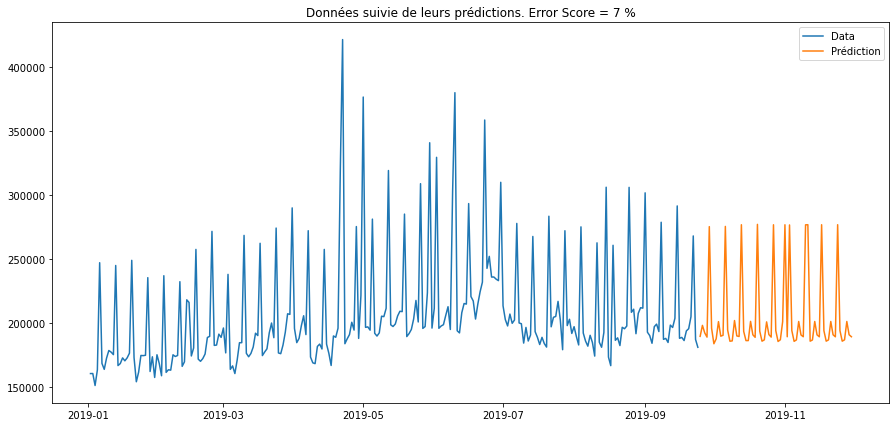

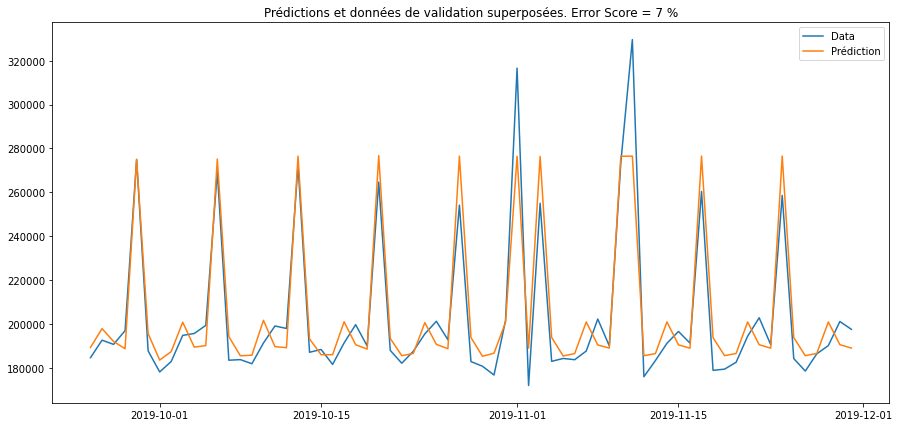

In [43]:
if not take_EG:
    pred = Recalc_with_feries(pred)

    err=cal_error(pred, val_main)

    train_main.plot(label="Data",legend=True, figsize=(15,7))
    pred.plot(label="Prédiction" ,legend=True)
    plt.title("Données suivie de leurs prédictions. Error Score = " + str(int(err*100)) + " %")
    if save_fig:
        plt.savefig(save_folder+ "/ALL_prediction1_recalcule.jpg")
    plt.show()

    val_main.plot(label="Data",legend=True, figsize=(15,7))
    pred.plot(label="Prédiction" ,legend=True)
    plt.title("Prédictions et données de validation superposées. Error Score = " + str(int(err*100)) + " %")
    if save_fig:
        plt.savefig(save_folder+ "/ALL_prediction2_recalcule.jpg")
    plt.show()


In [44]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~720secondes


## *Prediction du CA en fonction du temps par Magasin*

In [24]:
sql_command = '''  
SELECT [MAGASIN.KEY]
      ,[Magasin.Libelle_magasin]
FROM ['''+DB+'''].[DWH].[Dim_Magasin]
'''
print(sql_command)


conn = engine.connect()
df_magasin = pd.read_sql(sql_command, conn)
conn.close()


print(df_magasin)

  
SELECT [MAGASIN.KEY]
      ,[Magasin.Libelle_magasin]
FROM [Archive2018_2019_prod].[DWH].[Dim_Magasin]

    MAGASIN.KEY Magasin.Libelle_magasin
0            -1                       ?
1             1                    None
2             2                  GENVAL
3             3            OHAIN F 2020
4             4                 JURBISE
..          ...                     ...
84           84    Franchise Uccle 2020
85           85           EXPANSION 535
86           86           EXPANSION 536
87           87           EXPANSION 537
88           88  DLTLU Match Laudelange

[89 rows x 2 columns]


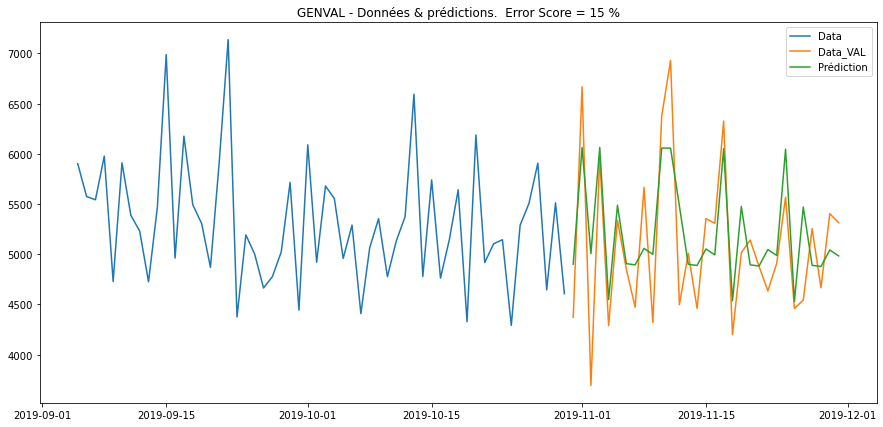

Time taken for magasin 2/65 GENVAL: ~11 secondes


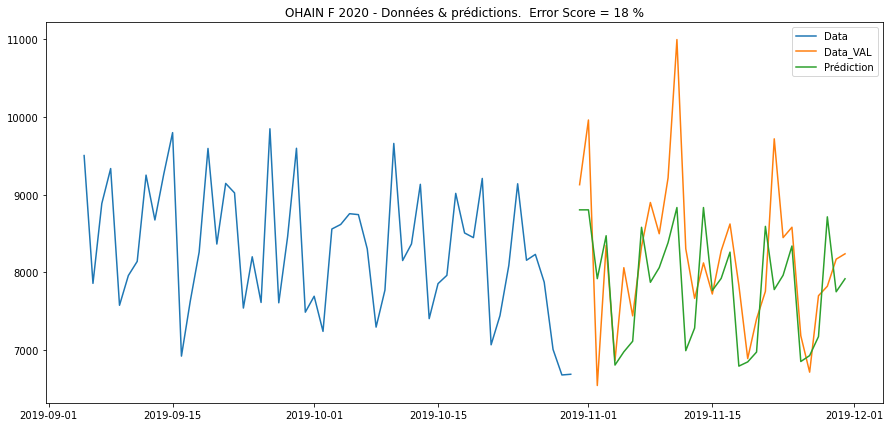

Time taken for magasin 3/65 OHAIN F 2020: ~19 secondes


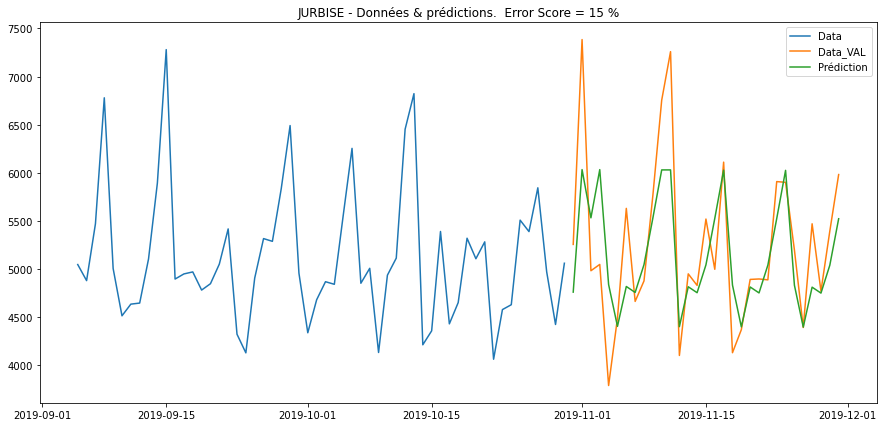

Time taken for magasin 4/65 JURBISE: ~13 secondes


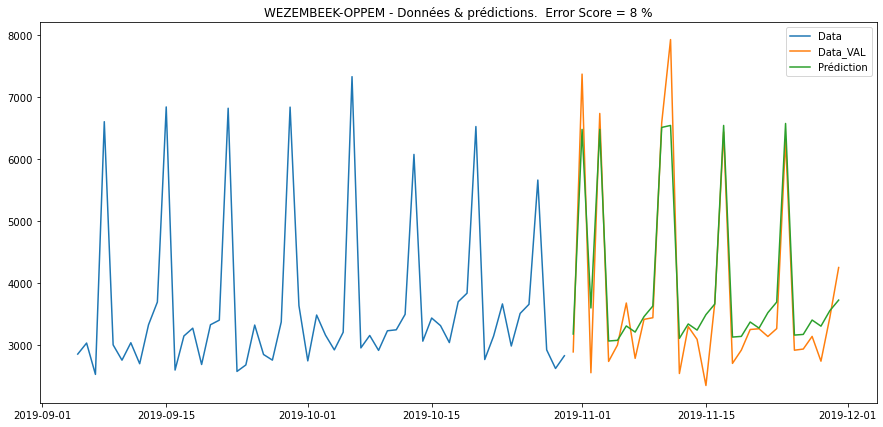

Time taken for magasin 7/65 WEZEMBEEK-OPPEM: ~5 secondes


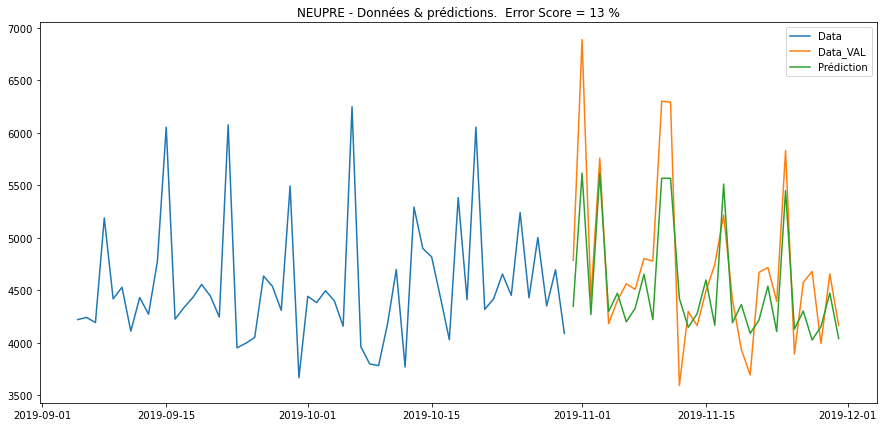

Time taken for magasin 9/65 NEUPRE: ~15 secondes


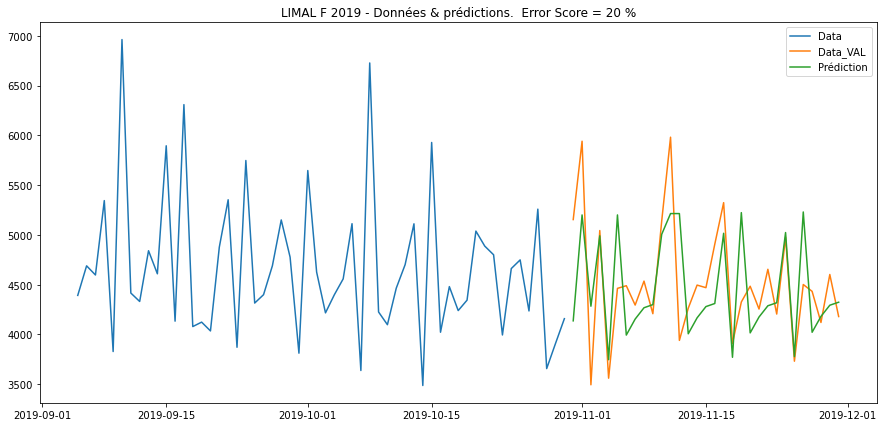

Time taken for magasin 11/65 LIMAL F 2019: ~12 secondes


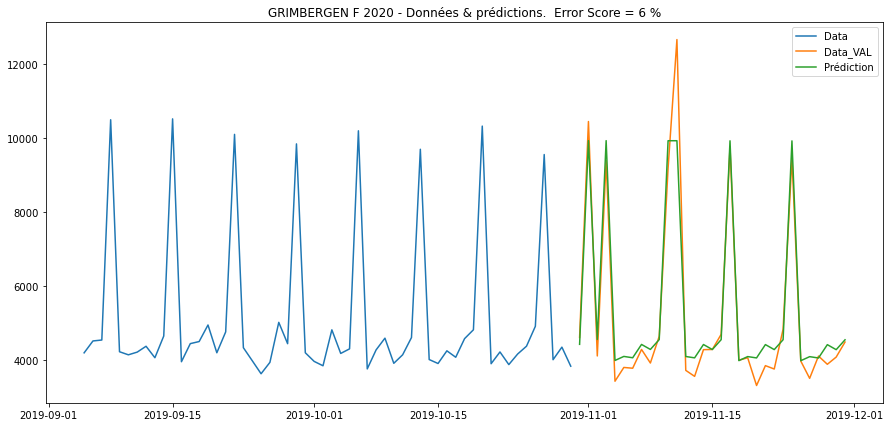

Time taken for magasin 13/65 GRIMBERGEN F 2020: ~11 secondes


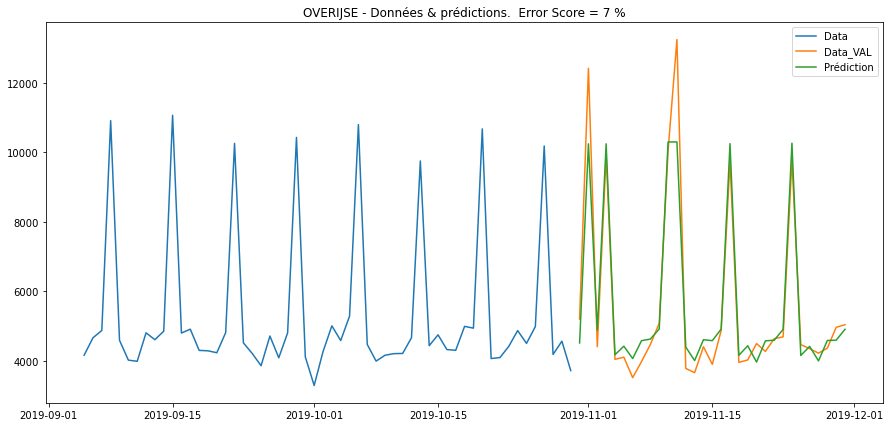

Time taken for magasin 14/65 OVERIJSE: ~12 secondes


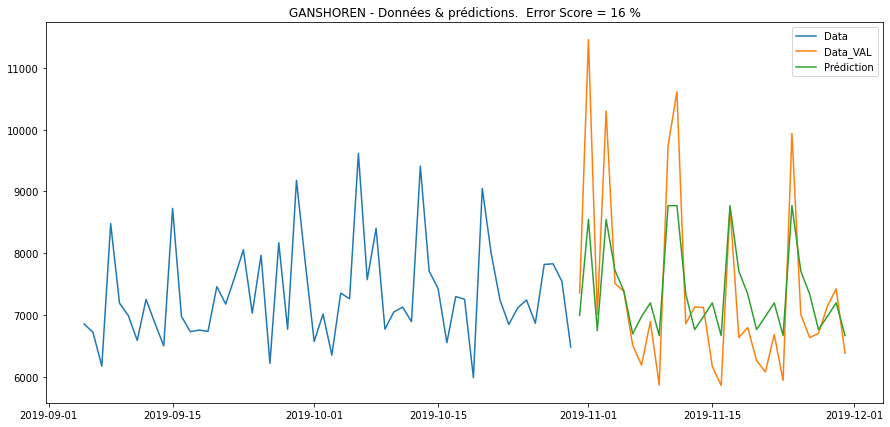

Time taken for magasin 15/65 GANSHOREN: ~8 secondes


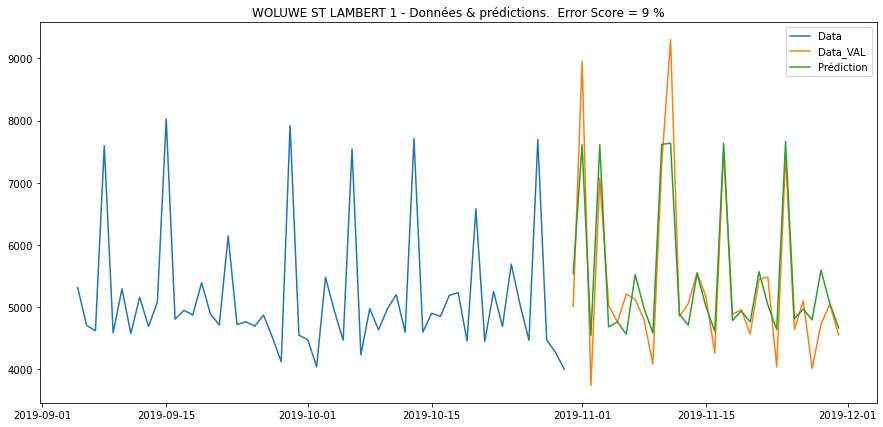

Time taken for magasin 16/65 WOLUWE ST LAMBERT 1: ~9 secondes


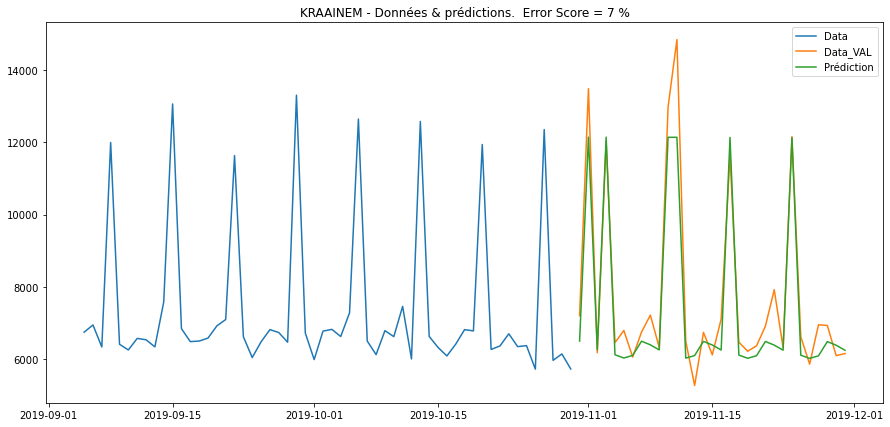

Time taken for magasin 17/65 KRAAINEM: ~12 secondes


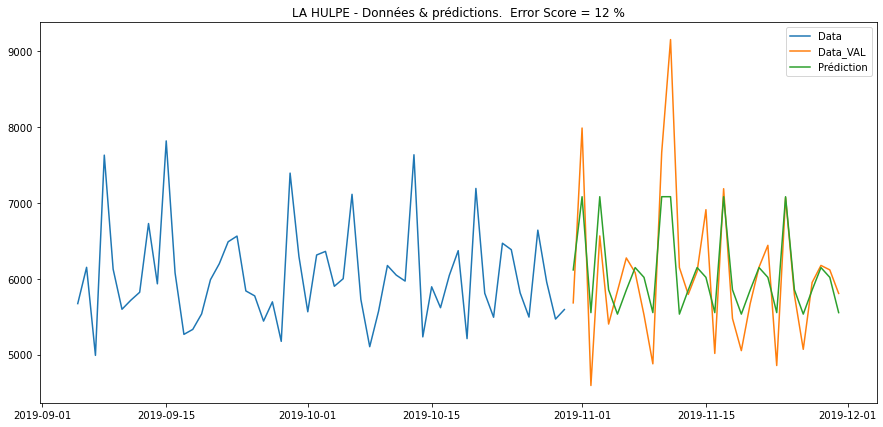

Time taken for magasin 19/65 LA HULPE: ~10 secondes


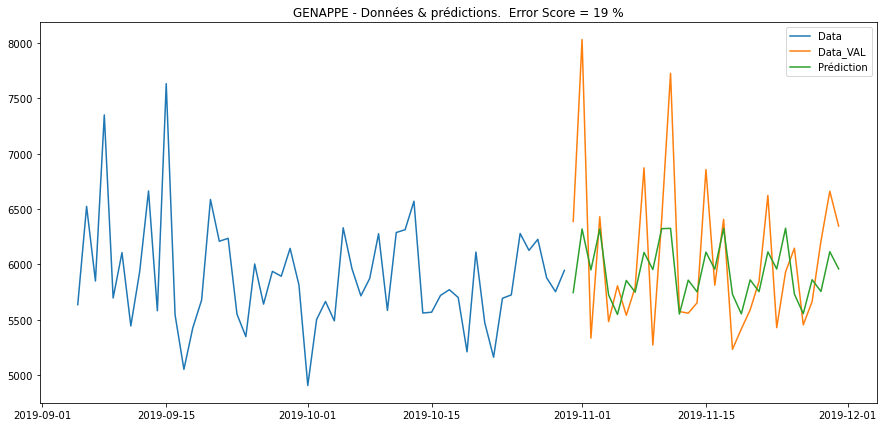

Time taken for magasin 21/65 GENAPPE: ~12 secondes


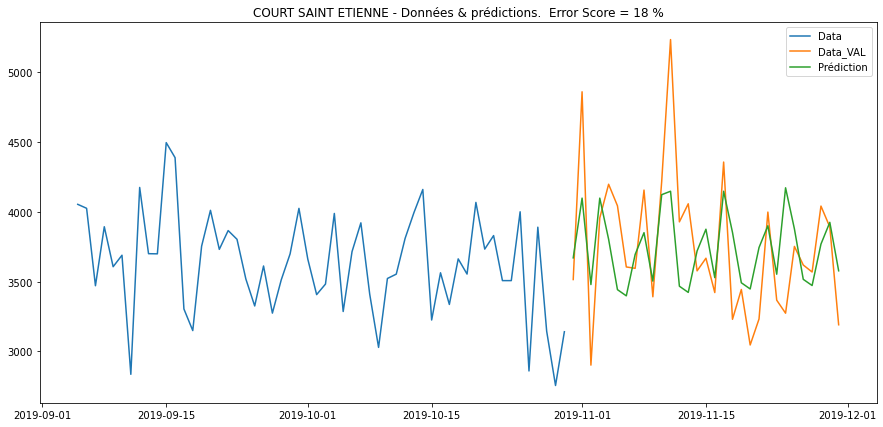

Time taken for magasin 22/65 COURT SAINT ETIENNE: ~5 secondes


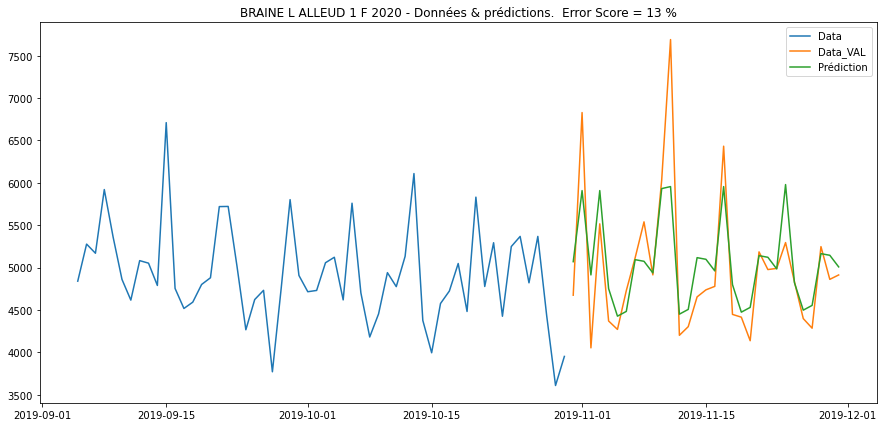

Time taken for magasin 24/65 BRAINE L ALLEUD 1 F 2020: ~5 secondes


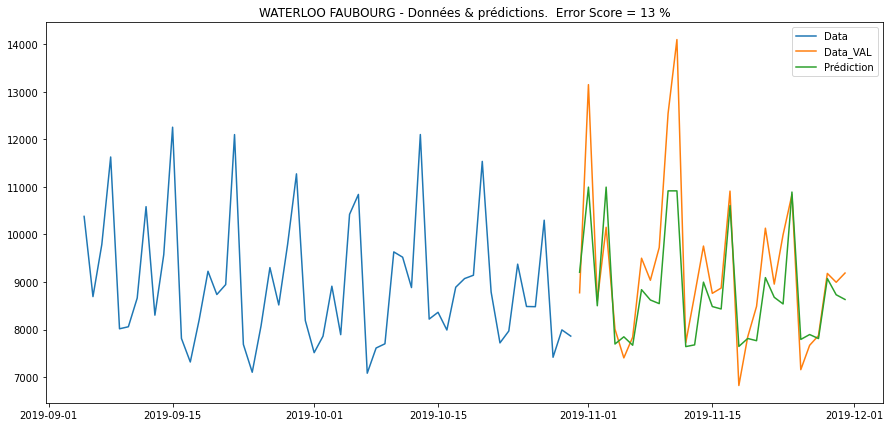

Time taken for magasin 25/65 WATERLOO FAUBOURG: ~16 secondes


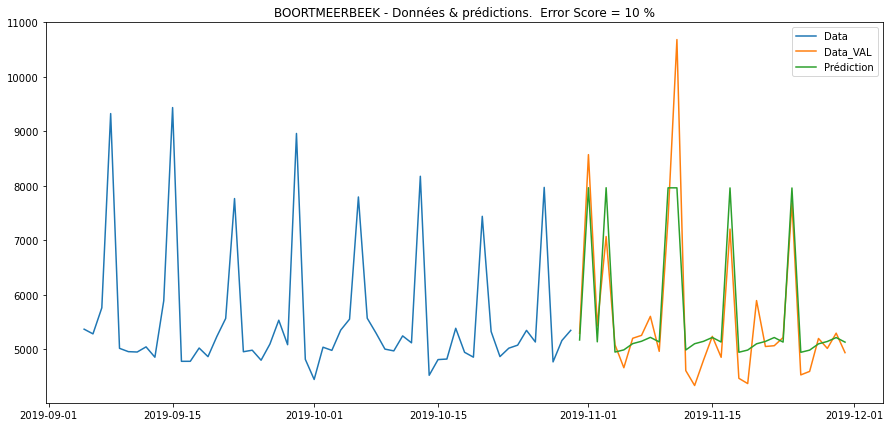

Time taken for magasin 29/65 BOORTMEERBEEK: ~15 secondes


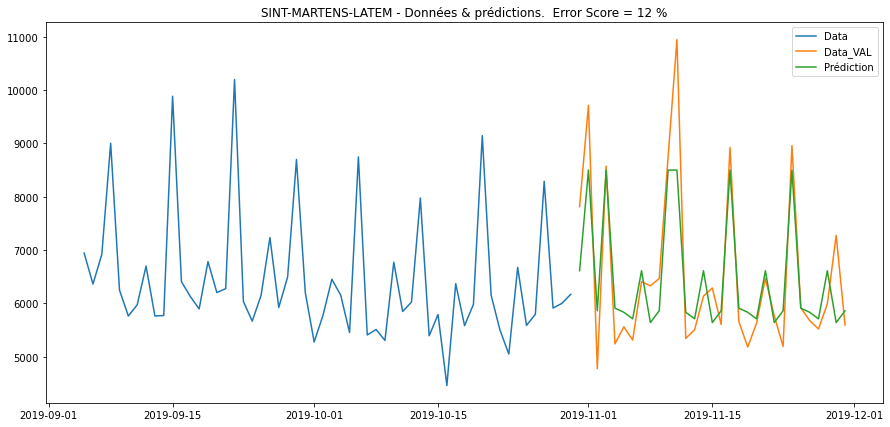

Time taken for magasin 30/65 SINT-MARTENS-LATEM: ~6 secondes


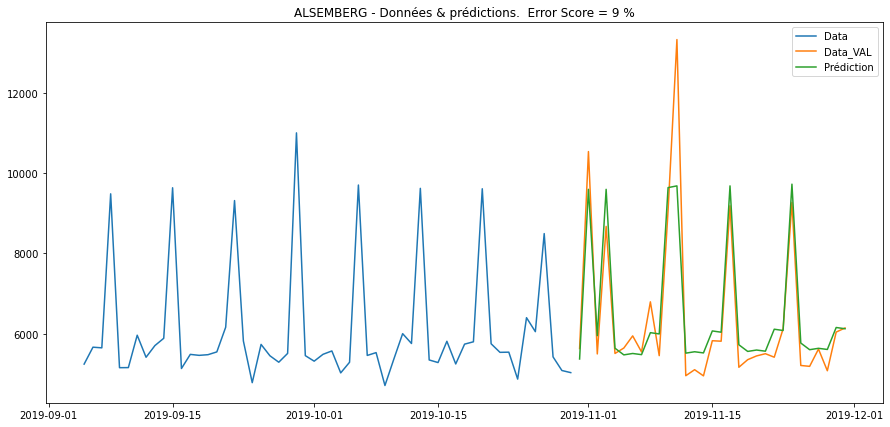

Time taken for magasin 32/65 ALSEMBERG: ~5 secondes


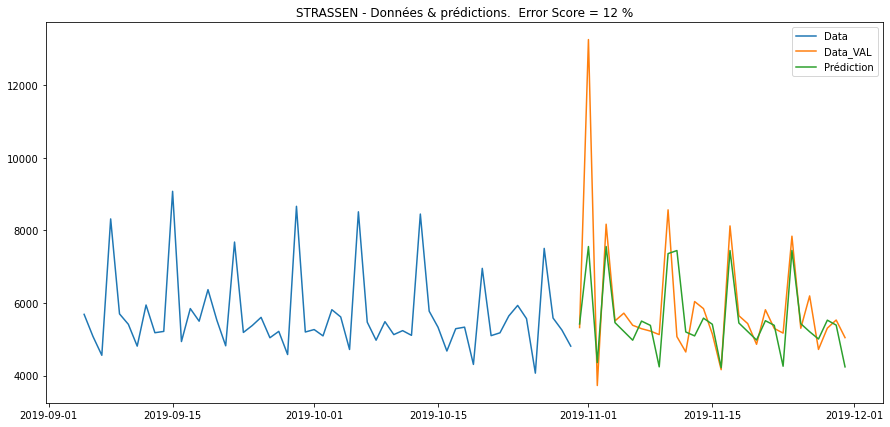

Time taken for magasin 33/65 STRASSEN: ~13 secondes


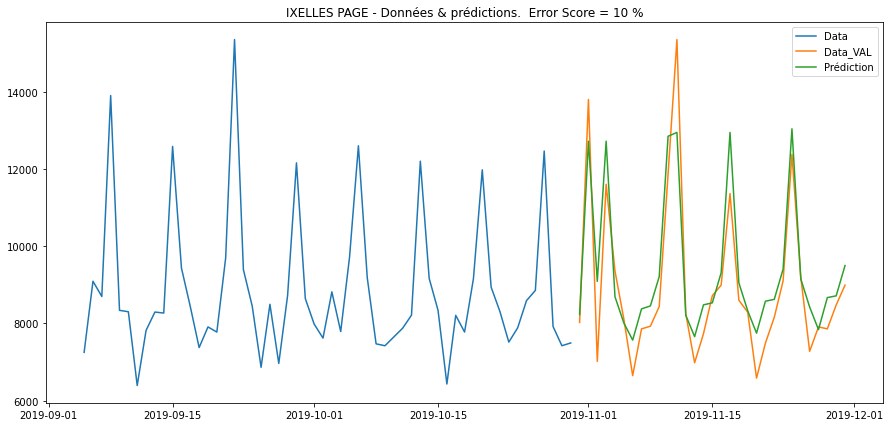

Time taken for magasin 34/65 IXELLES PAGE: ~6 secondes


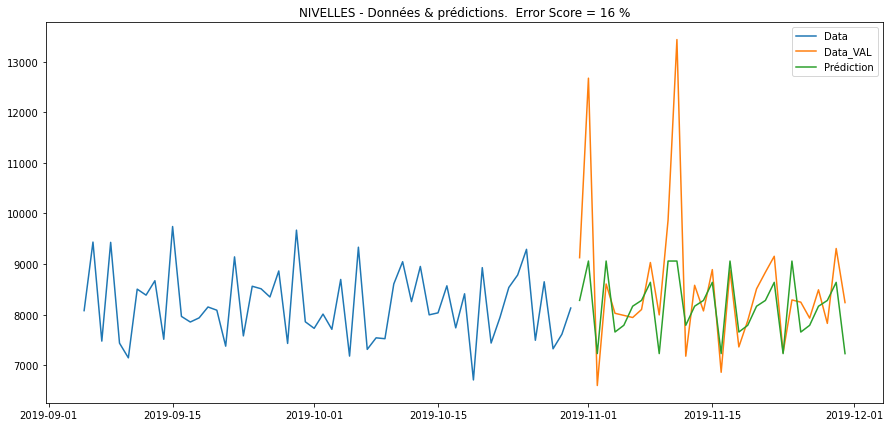

Time taken for magasin 39/65 NIVELLES: ~9 secondes


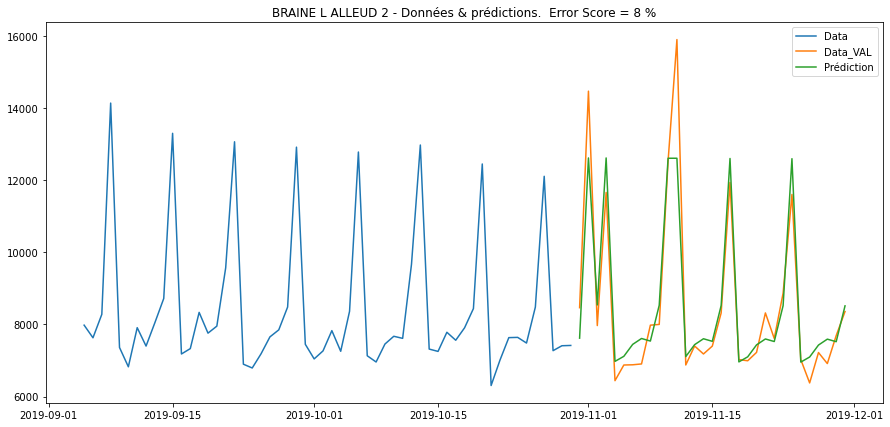

Time taken for magasin 40/65 BRAINE L ALLEUD 2: ~10 secondes


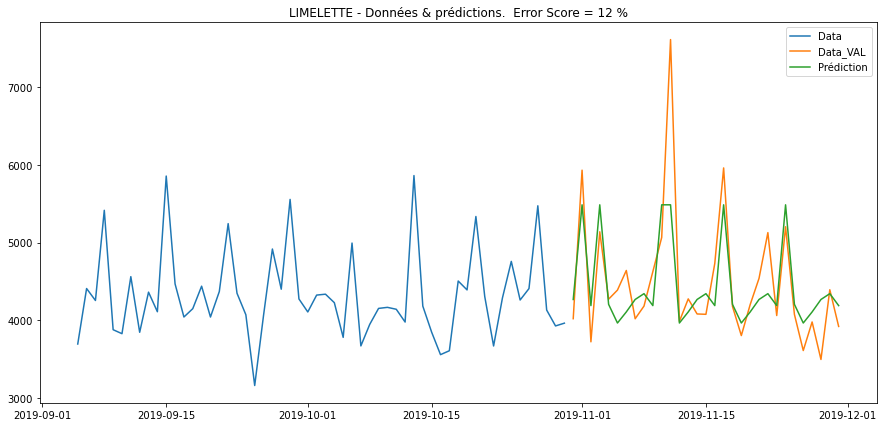

Time taken for magasin 41/65 LIMELETTE: ~9 secondes


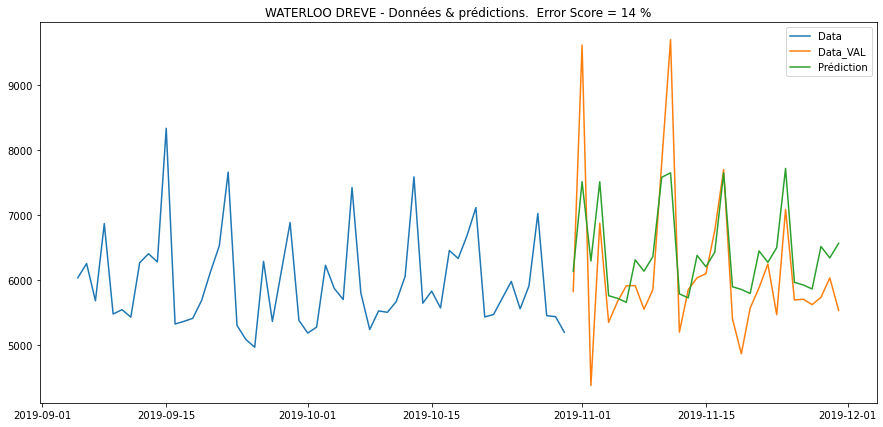

Time taken for magasin 42/65 WATERLOO DREVE: ~4 secondes


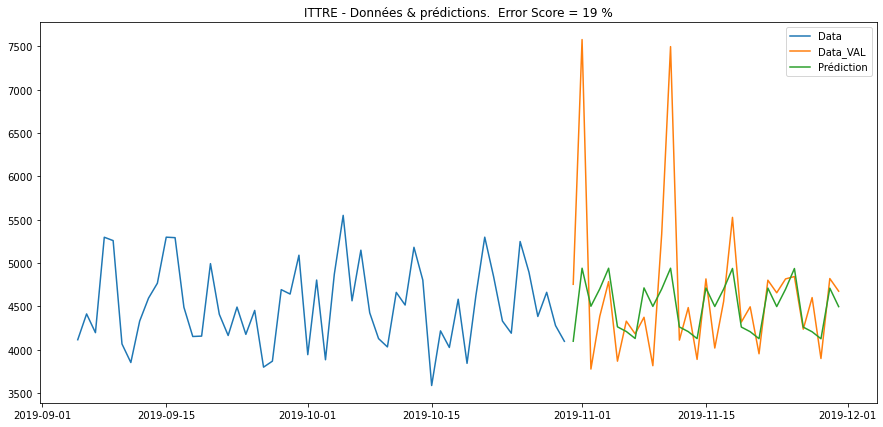

Time taken for magasin 43/65 ITTRE: ~15 secondes


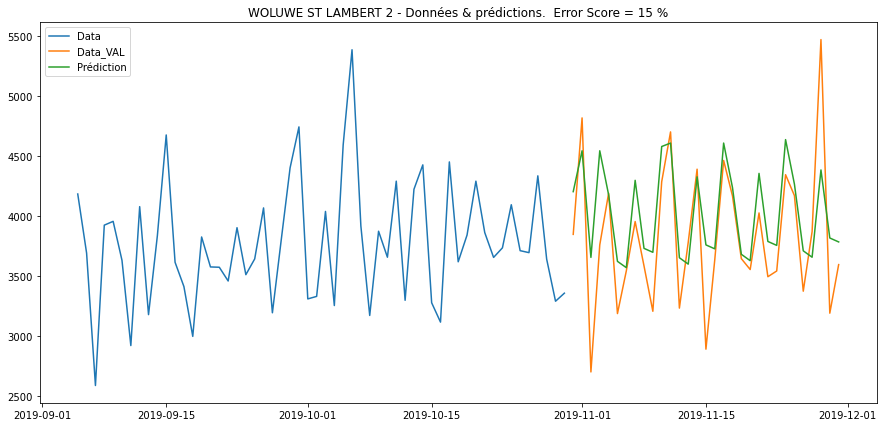

Time taken for magasin 44/65 WOLUWE ST LAMBERT 2: ~10 secondes


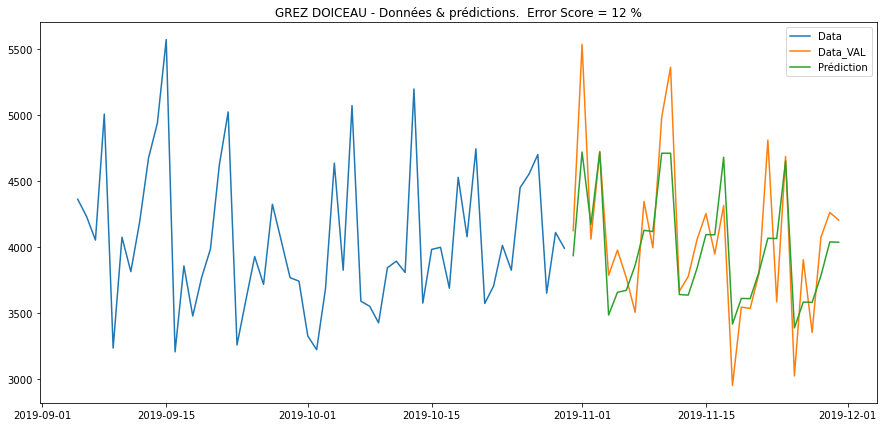

Time taken for magasin 46/65 GREZ DOICEAU: ~7 secondes


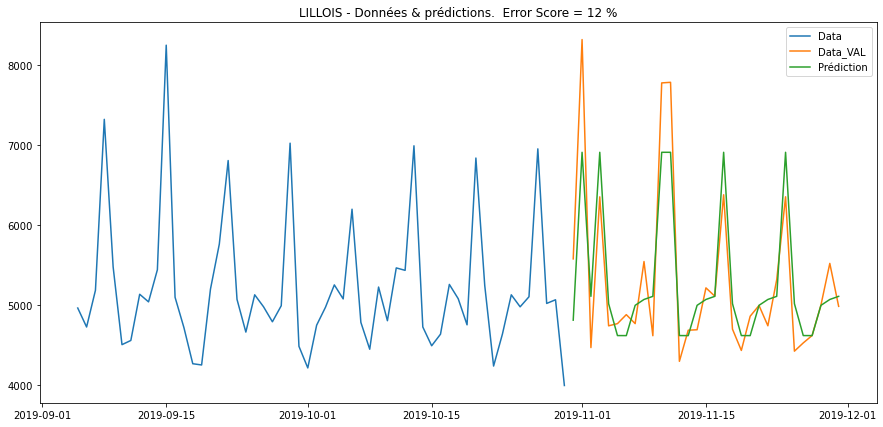

Time taken for magasin 49/65 LILLOIS: ~6 secondes


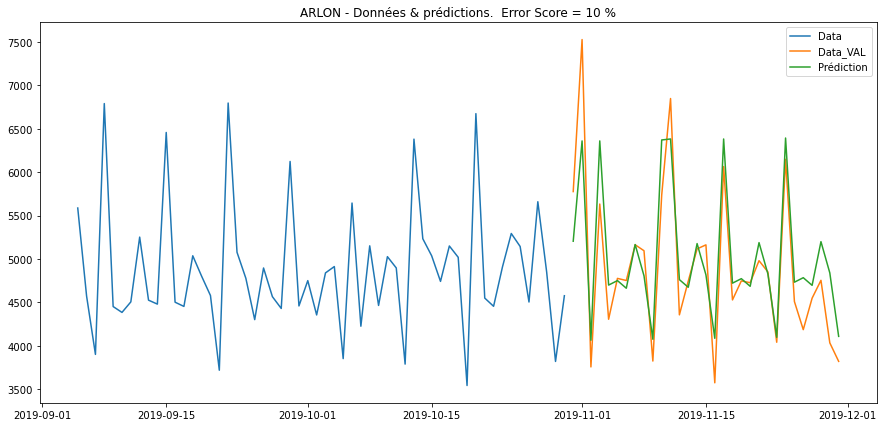

Time taken for magasin 50/65 ARLON: ~5 secondes


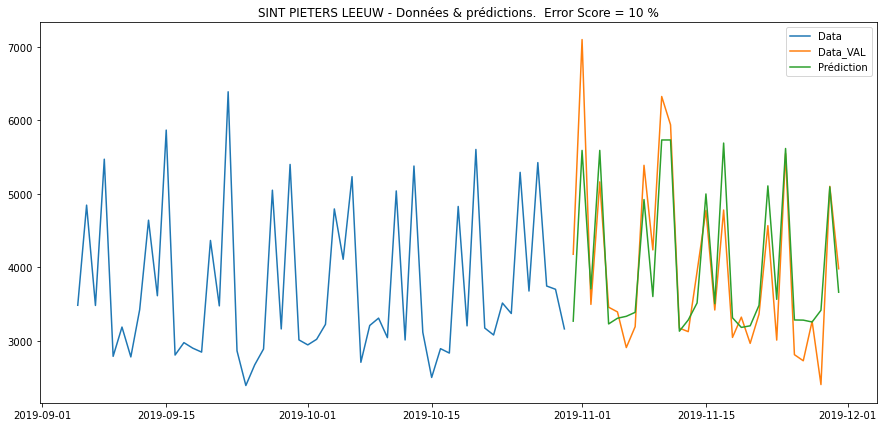

Time taken for magasin 59/65 SINT PIETERS LEEUW: ~36 secondes


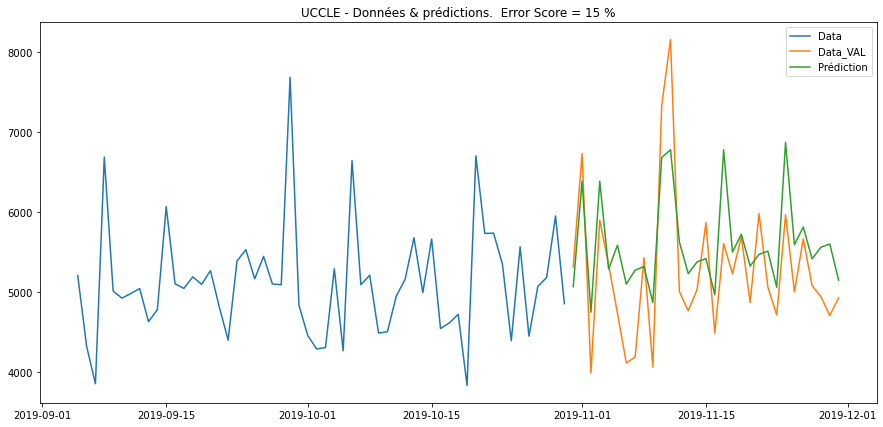

Time taken for magasin 61/65 UCCLE: ~23 secondes


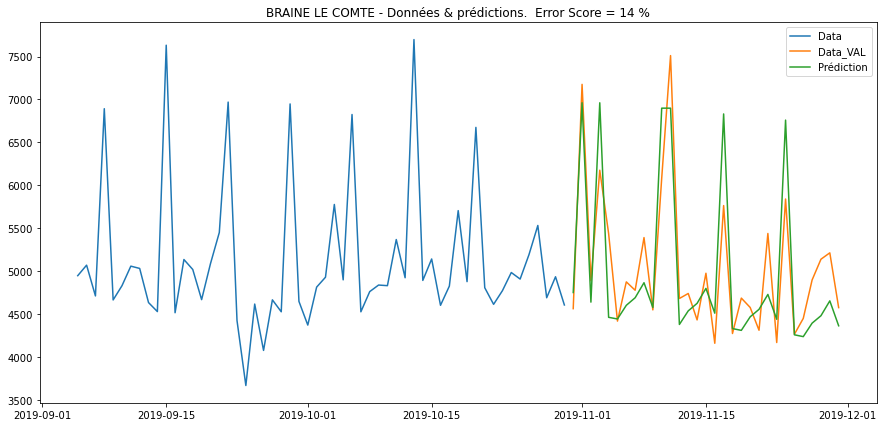

Time taken for magasin 62/65 BRAINE LE COMTE: ~8 secondes


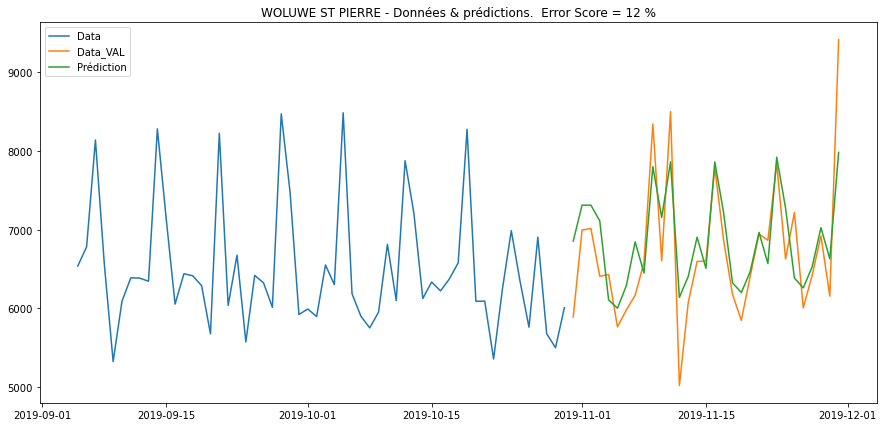

Time taken for magasin 64/65 WOLUWE ST PIERRE: ~5 secondes


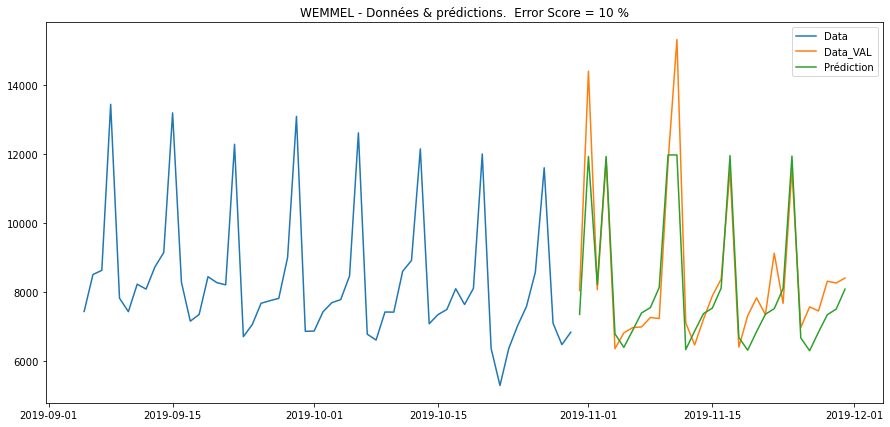

Time taken for magasin 65/65 WEMMEL: ~16 secondes
bad: 5   moyen: 18   good: 12


In [25]:
all_mag_key = set(df[MAGASIN + ".KEY"])

all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
all_mag_rec = {mag_key:{} for mag_key in all_mag_key}

ind_temps = len(column_wanted)
ind_recette = column_wanted.index("["+RECETTE+"]")
ind_mag = column_wanted.index("["+MAGASIN + ".KEY]")

for val in df.values:
    if not val[ind_temps] in all_mag_rec[val[ind_mag]].keys():
        all_mag_rec[val[ind_mag]][val[ind_temps]] = 0
    all_mag_rec[val[ind_mag]][val[ind_temps]] += val[ind_recette]


bad, moyen, good = 0,0,0    
    
for mag_key in all_mag_key:
    start = time()
    
    Tot_recette_day = all_mag_rec[mag_key]
    mag_lib = all_mag_lib[mag_key]
    
    Tot_recette_day = dict(sorted(Tot_recette_day.items()))
    
    df_recette_day_mag = pd.DataFrame(data  = Tot_recette_day.values(), 
                                      index = Tot_recette_day.keys(), 
                                      columns = ["Total Recette"])
    
    if not df_recette_day_mag.empty:
        if len(df_recette_day_mag.values) > season * 10:
            ts_main_mag     = pd.Series(data = df_recette_day_mag[df_recette_day_mag.columns[0]], 
                                                                    index=df_recette_day_mag.index)
            

            train_main_mag, val_main_mag = train_test_split(ts_main_mag,test_size = 1-alpha, shuffle = False)

            
            pred_mag        = pm.auto_arima(train_main_mag,d=0,D=1,seasonal=True, m=season, 
                                        method = METHOD).fit_predict(train_main_mag, n_periods = len(val_main_mag))
            pred_mag        = pd.Series(data=pred_mag,
                                        index=[train_main_mag.index[-1] +timedelta(days=i+1) for i in range(len(pred_mag))])

            if not take_EG:
                pred_mag        = Recalc_with_feries(pred_mag)
            
            err = cal_error(pred_mag, val_main_mag)
            
            train_main_mag[-season*8:].plot(label="Data",legend=True, figsize=(15,7))
            val_main_mag.plot(label="Data_VAL",legend=True, figsize=(15,7))
            pred_mag.plot(label = "Prédiction" ,legend=True)
            plt.title(mag_lib + " - Données & prédictions.  Error Score = " + str(int(err*100)) + " %")
            if save_fig:
                plt.savefig(save_folder+ "/MAG-" +mag_lib + "-prediction.jpg")
            plt.show()
            
            bad   += int(bool(err>BAD))
            moyen += int(bool(err<BAD and err >GOOD))
            good  += int(bool(err<GOOD))
            
        else:  
            df_recette_day_mag.plot(figsize=(15,7), title = mag_lib)
            plt.show()
    
    print("Time taken for magasin " + str(mag_key) +"/"+str(max(all_mag_key))+ " " + (mag_lib if mag_lib != None else "?")
          + ": ~" + str(int(time() - start)) + " secondes") 
    
print("bad:",bad,"  moyen:", moyen,"  good:", good)

In [26]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~476secondes


In [27]:
results = {'nm'    :[12.929560,108.056167],
           'bfgs'  :[12.620287,556.962607],
           'powell':[12.670451,379.438504],
           'lbfgs' :[12.481309,419.550971],
           'cg'    :[15.907566,217.617969]}

all_mag_key = set(df[MAGASIN + ".KEY"])

all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
all_mag_rec = {mag_key:{} for mag_key in all_mag_key}

ind_temps = len(column_wanted)
ind_recette = column_wanted.index("["+RECETTE+"]")
ind_mag = column_wanted.index("["+TABLE+".MAGASIN.KEY]")

for val in df.values:
    if not val[ind_temps] in all_mag_rec[val[ind_mag]].keys():
        all_mag_rec[val[ind_mag]][val[ind_temps]] = 0
    all_mag_rec[val[ind_mag]][val[ind_temps]] += val[ind_recette]

    
all_df = {}    
for mag_key in all_mag_key:
    Tot_recette_day = all_mag_rec[mag_key]
    mag_lib = all_mag_lib[mag_key]

    Tot_recette_day = dict(sorted(Tot_recette_day.items()))
    
    if len(Tot_recette_day.values()) > season * 8:
        all_df[mag_key] =  (mag_lib, pd.DataFrame(data = Tot_recette_day.values(), 
                                          index=Tot_recette_day.keys(), 
                                          columns = ["Total Recette"]))

for m in results.keys():
    if len(results[m]) > 1:
        continue
    
    precision = 0
    temps = time()
    n = 20  #Max n ~= 36
    
    for (mag_key, (mag_lib, df_recette_day_mag)) in list(all_df.items())[:n]:
        start = time()

        ts_main_mag     = pd.Series(data = df_recette_day_mag[df_recette_day_mag.columns[0]], 
                                                                index=df_recette_day_mag.index)

        train_main_mag, val_main_mag = train_test_split(ts_main_mag,test_size = 1-alpha, shuffle = False)
        
        pred_mag        = pm.auto_arima(train_main_mag,d=0,D=1,seasonal=True, m=season, 
                                        method = m).fit_predict(train_main_mag, n_periods = len(val_main_mag))
        pred_mag        = pd.Series(data=pred_mag,
                                    index=[train_main_mag.index[-1] +timedelta(days=i+1) for i in range(len(pred_mag))])
        pred_mag        = Recalc_with_feries(pred_mag)
        
        err             = cal_error(pred_mag, val_main_mag)
        precision      += err

        print("Time taken for magasin " + str(mag_key) + " " + (mag_lib if mag_lib != None else "?")
              + ": ~" + str(int(time() - start)) + " secondes. " + 
              "\nMethod = " + m + " Error = " + str(err)) 

    
    results[m] = [precision*100/n, time()-temps]
    
print('-----------------------------------------------------------------')
print(pd.DataFrame(data = results.values(), 
                index=results.keys(), 
                columns = ["Erreur Moyenne (%)", "Temps Process"]))
print("Newton-Raphson & Newton Conjugate Gradient methods don't work for non-convex fonction.")
print("Powell doesn't seem to work for all dataset ?")
print("Basinhopping really takes a lot of time to run.")
print('-----------------------------------------------------------------')

-----------------------------------------------------------------
        Erreur Moyenne (%)  Temps Process
nm               12.929560     108.056167
bfgs             12.620287     556.962607
powell           12.670451     379.438504
lbfgs            12.481309     419.550971
cg               15.907566     217.617969
Newton-Raphson & Newton Conjugate Gradient methods don't work for non-convex fonction.
Powell doesn't seem to work for all dataset ?
Basinhopping really takes a lot of time to run.
-----------------------------------------------------------------
